In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

tf.__version__

'2.10.0'

### Gen catcha

In [ ]:
# import cv2

# imt = cv2.imread('./save_temp/captcha_mst/jpg/27hf8.jpg', 0)
# imt.shape

In [13]:
# coding: utf-8
"""
    captcha.image
    ~~~~~~~~~~~~~

    Generate Image CAPTCHAs, just the normal image CAPTCHAs you are using.
"""

import os
import random
import typing as t
from PIL.Image import new as createImage, Image, QUAD, BILINEAR
from PIL.ImageDraw import Draw, ImageDraw
from PIL.ImageFilter import SMOOTH
from PIL.ImageFont import FreeTypeFont, truetype
from io import BytesIO


ColorTuple = t.Union[t.Tuple[int, int, int], t.Tuple[int, int, int, int]]
GEN_CAPTCHA_DIR_ONE = './save_temp/captcha_test/gen_captcha/one_char/'
GEN_CAPTCHA_DIR_FIVE = './save_temp/captcha_test/gen_captcha/five_chars/'
DEFAULT_FONTS = glob.glob(os.path.join(os.path.join('./save_temp/fonts/selected_fonts/'), "*"))

class ImageCaptcha:
    """Create an image CAPTCHA.

    Many of the codes are borrowed from wheezy.captcha, with a modification
    for memory and developer friendly.

    ImageCaptcha has one built-in font, DroidSansMono, which is licensed under
    Apache License 2. You should always use your own fonts::

        captcha = ImageCaptcha(fonts=['/path/to/A.ttf', '/path/to/B.ttf'])

    You can put as many fonts as you like. But be aware of your memory, all of
    the fonts are loaded into your memory, so keep them a lot, but not too
    many.

    :param width: The width of the CAPTCHA image.
    :param height: The height of the CAPTCHA image.
    :param fonts: Fonts to be used to generate CAPTCHA images.
    :param font_sizes: Random choose a font size from this parameters.
    """
    lookup_table: t.List[int] = [int(i * 1.97) for i in range(256)]

    def __init__(
            self,
            width: int = 160,
            height: int = 60,
            fonts: t.Optional[t.List[str]] = None,
            font_sizes: t.Optional[t.Tuple[int]] = None):
        self._width = width
        self._height = height
        self._fonts = fonts or DEFAULT_FONTS
        self._font_sizes = font_sizes or (42, 50, 56)
        self._truefonts: t.List[FreeTypeFont] = []

    @property
    def truefonts(self) -> t.List[FreeTypeFont]:
        if self._truefonts:
            return self._truefonts
        self._truefonts = [
            truetype(n, s)
            for n in self._fonts
            for s in self._font_sizes
        ]
        return self._truefonts

    @staticmethod
    def create_noise_curve(image: Image, color: ColorTuple) -> Image:
        w, h = image.size
        x1 = random.randint(0, int(w / 5))
        x2 = random.randint(w - int(w / 5), w)
        y1 = random.randint(int(h / 5), h - int(h / 5))
        y2 = random.randint(y1, h - int(h / 5))
        points = [x1, y1, x2, y2]
        end = random.randint(160, 200)
        start = random.randint(0, 20)
        Draw(image).arc(points, start, end, fill=color)
        return image

    @staticmethod
    def create_noise_dots(
            image: Image,
            color: ColorTuple,
            width: int = 3,
            number: int = 30) -> Image:
        draw = Draw(image)
        w, h = image.size
        while number:
            x1 = random.randint(0, w)
            y1 = random.randint(0, h)
            draw.line(((x1, y1), (x1 - 1, y1 - 1)), fill=color, width=width)
            number -= 1
        return image

    def _draw_character(
            self,
            c: str,
            draw: ImageDraw,
            color: ColorTuple) -> Image:
        font = random.choice(self.truefonts)
        _, _, w, h = draw.multiline_textbbox((1, 1), c, font=font)

        dx1 = random.randint(0, 4)
        dy1 = random.randint(0, 6)
        im = createImage('RGBA', (w + dx1, h + dy1))
        Draw(im).text((dx1, dy1), c, font=font, fill=color)

        # rotate
        im = im.crop(im.getbbox())
        # im = im.rotate(random.uniform(-30, 30), BILINEAR, expand=True)

        # warp
        dx2 = w * random.uniform(0.1, 0.3)
        dy2 = h * random.uniform(0.2, 0.3)
        x1 = int(random.uniform(-dx2, dx2))
        y1 = int(random.uniform(-dy2, dy2))
        x2 = int(random.uniform(-dx2, dx2))
        y2 = int(random.uniform(-dy2, dy2))
        w2 = w + abs(x1) + abs(x2)
        h2 = h + abs(y1) + abs(y2)
        data = (
            x1, y1,
            -x1, h2 - y2,
            w2 + x2, h2 + y2,
            w2 - x2, -y1,
        )
        im = im.resize((w2, h2))
        # im = im.transform((w, h), QUAD, data)
        return im

    def create_captcha_image(
            self,
            chars: str,
            color: ColorTuple,
            background: ColorTuple) -> Image:
        """Create the CAPTCHA image itself.

        :param chars: text to be generated.
        :param color: color of the text.
        :param background: color of the background.

        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """
        image = createImage('RGB', (self._width, self._height), background)
        # image = createImage('RGB', (self._width, self._height))
        draw = Draw(image)

        images: t.List[Image] = []
        for c in chars:
            # if random.random() > 0.5:
            #     images.append(self._draw_character(" ", draw, color))
            images.append(self._draw_character(c, draw, color))

        text_width = sum([im.size[0] for im in images])

        width = max(text_width, self._width)
        image = image.resize((width, self._height))

        average = int(text_width / len(chars))
#         rand = int(0.25 * average)
        offset = int(average * 0.1)

        for im in images:
            w, h = im.size
            mask = im.convert('L').point(self.lookup_table)
            image.paste(im, (offset, int((self._height - h) / 2)), mask)
            # offset = offset + w + random.randint(-rand, 0)
            offset = offset + w # + random.randint(-int(0.005 * average), 0)

        if width > self._width:
            image = image.resize((self._width, self._height))

        return image

    def generate_image(self, chars: str) -> Image:
        """Generate the image of the given characters.

        :param chars: text to be generated.
        """
        # background = random_color(238, 255)
        # color = random_color(10, 200, random.randint(220, 255))
        background = random_color(255, 255)
        color = (255, 0, 0)
        im = self.create_captcha_image(chars, color, background)
        # self.create_noise_dots(im, color)
        # self.create_noise_curve(im, color)
        im = im.filter(SMOOTH)
        return im

    def generate(self, chars: str, format: str = 'png') -> BytesIO:
        """Generate an Image Captcha of the given characters.

        :param chars: text to be generated.
        :param format: image file format
        """
        im = self.generate_image(chars)
        out = BytesIO()
        im.save(out, format=format)
        out.seek(0)
        return out

    def write(self, chars: str, output: str, format: str = 'png') -> None:
        """Generate and write an image CAPTCHA data to the output.

        :param chars: text to be generated.
        :param output: output destination.
        :param format: image file format
        """
        im = self.generate_image(chars)
        im.save(output, format=format)


def random_color(
        start: int,
        end: int,
        opacity: t.Optional[int] = None) -> ColorTuple:
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (red, green, blue)
    return (red, green, blue, opacity)

# https://github.com/lepture/captcha/blob/master/src/captcha/image.py
# from captcha.image import ImageCaptcha

# image = ImageCaptcha(height=50, width=130, font_sizes=[40])

# for i in range(10):
#     data = image.generate(str(i))
#     image.write(str(i), DATA_TRAIN_DIR + str(i) + '.jpg')

import itertools, random, uuid

def _gen_captcha(img_dir, num_per_image, n, width, height, choices, max_images_count):

    image = ImageCaptcha(width=width, height=height, font_sizes=[25])

    remain_count = max_images_count
    epoche_count = len(list(itertools.permutations(choices, num_per_image)))

    # print('generating %s epoches of captchas in %s.' % (n, img_dir))

    for _ in range(n):
        samples = itertools.permutations(choices, num_per_image)
        samples = random.sample(list(samples), remain_count)
        if remain_count > 0 and remain_count < epoche_count:
            # print('only %s records used in epoche %s. epoche_count: %s' % (remain_count, _+1, epoche_count))
            samples = random.sample(list(samples), remain_count)
        
        for i in samples:
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.jpg' % (captcha, uuid.uuid4()))
            # fn = os.path.join(img_dir, '%s.jpg' % (captcha))
            image.write(captcha, fn)
            
        if n < 20:
            print('(%s/%s) epoches finished' % (_+1, n))
            

SELECTED_CHARS = '2345678abcdefghkmnprwxy'
_gen_captcha(GEN_CAPTCHA_DIR_ONE, 1, 10000, 50, 50, SELECTED_CHARS, 1)

# SELECTED_CHARS = '2345678abcdefghkmnprwxy'
_gen_captcha(GEN_CAPTCHA_DIR_FIVE, 5, 10000, 130, 50, SELECTED_CHARS, 1)

/var/folders/sx/j73w_qnn72b13k4_lvfdxsz57p4wgj/T/ipykernel_1426/3370653664.py:12: DeprecationWarning: QUAD is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.QUAD instead.
  from PIL.Image import new as createImage, Image, QUAD, BILINEAR
/var/folders/sx/j73w_qnn72b13k4_lvfdxsz57p4wgj/T/ipykernel_1426/3370653664.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  from PIL.Image import new as createImage, Image, QUAD, BILINEAR


In [4]:
print("Done")

Done


### Separated characters from catcha

In [8]:
import os
from PIL import Image
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import math
from datetime import datetime
import io

def convert_png_jpg_dir(dir_png, dir_jpg):
    def convert_png_jpg_(png_path, jpg_path):
        try:
            png_image = Image.open(png_path)
            jpg_image = Image.new("RGB", png_image.size, (255, 255, 255))  # Creating a white background
            jpg_image.paste(png_image, (0, 0), png_image)
            jpg_image.save(jpg_path, "JPEG", quality=100)
            print(f"Conversion successful: {png_path} -> {jpg_path}")
        except Exception as e:
            print(f"Error during conversion: {e}")

    # Get a list of all files in the directory
    file_list = os.listdir(dir_png)
    file_chars = {}

    # Iterate over the files and print their names
    for file_name in file_list:
        if os.path.isfile(os.path.join(dir_png, file_name)):
            file_png = os.path.join(dir_png, file_name)
            file_jpg = os.path.join(dir_jpg, file_name.replace(".png", ".jpg"))
            chars_ls = list(file_name.replace(".png", ""))
            for pos, c in enumerate(chars_ls):
                file_chars[c] = (file_chars[c] + [(file_jpg, pos)]) if c in file_chars else [(file_jpg, pos)]
            # convert_png_jpg_(file_png, file_jpg)
            
    return file_chars
        
MST_DIR_PNG = './save_temp/captcha_test/captcha_mst/png/'  # Replace with the path to your directory
MST_DIR_JPG = './save_temp/captcha_test/captcha_mst/jpg/'

file_chars = convert_png_jpg_dir(MST_DIR_PNG, MST_DIR_JPG)

# sorted
file_chars = dict(sorted(file_chars.items()))
file_chars = {c: sorted(file_chars[c], key=lambda x: x[1])  for c in file_chars}
list(file_chars.keys())

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'k',
 'm',
 'n',
 'o',
 'p',
 'r',
 'w',
 'x',
 'y']

In [9]:
def remove_noise(fimg):
    def convert_jpg_(fimg):

        png_image = Image.open(fimg) if type(fimg) is str else fimg

        jpg_image = Image.new("RGB", png_image.size, (255, 255, 255))  # Creating a white background
        jpg_image.paste(png_image, (0, 0), png_image)
        jpeg_array = np.array(jpg_image)

        return jpeg_array

    image = cv2.imread(fimg, cv2.IMREAD_UNCHANGED) if type(fimg) is str and '.jpg' in fimg else \
                    convert_jpg_(fimg)
    kernel = np.ones((2, 2), np.uint8)
    dilated_img = cv2.dilate(image, kernel, iterations=1)

    return dilated_img
    
# def remove_noise(fimg):
#     def convert_jpg_(fimg):
        
#         png_image = Image.open(fimg)
        
#         jpg_image = Image.new("RGB", png_image.size, (255, 255, 255))  # Creating a white background
#         jpg_image.paste(png_image, (0, 0), png_image)
#         jpeg_array = np.array(jpg_image)

#         return jpeg_array

#     image = convert_jpg_(fimg) if '.png' in fimg else \
#                     cv2.imread(fimg, cv2.IMREAD_UNCHANGED)
#     kernel = np.ones((2, 2), np.uint8)
#     dilated_img = cv2.dilate(image, kernel, iterations=1)
    
#     return dilated_img
    
def chop_multi_versions(img, num_chars, chop_wd = [0, -2, -4, 2, 4], chop_width=[0]):
    def find_first_position_(img):
        arr_pos = []

        for r in range(0, img.shape[0]):
            fwhite = None
            for c in range(0, img.shape[1]):
                s = sum(img[r][c])
                fwhite = c if s == 765 else fwhite            
                if fwhite is not None and (s != 765):  
                    arr_pos.append(c) if c < img.shape[1] - 3 else None
                    break
        return min(arr_pos)

    def find_last_position_(img):
        arr_pos = []

        for r in range(0, img.shape[0]):
            fwhite = None
            for c in range(0, img.shape[1]):
                c = img.shape[1] - c - 1
                s = sum(img[r][c])            
                fwhite = c if s == 765 else fwhite
                if fwhite is not None and (s != 765):
                    arr_pos.append(c) if c > 5 else None
                    break

        return max(arr_pos)

    def chop_first_last_(img, first_chop, last_chop):
        return np.array([img[i][first_chop:last_chop] for i in range(0, img.shape[0])])

    def chop_equal_(img, num_chars):
        equal_size = int(img.shape[1]/num_chars)
        return [img[0:img.shape[0], i:i+equal_size,:] for i in range(0, equal_size*num_chars, equal_size)]


    def chop_multi_(img, num_chars, chop_wd = [0, -2, -4, 2, 4], chop_width=[0]):
        equal_size = int(img.shape[1]/num_chars)
        chop_multi = [[] for i in range(0, num_chars)]
        chop_size = [(x, x, w) for x in chop_wd for w in chop_width]        
        for i in range(0, num_chars):
            for s in chop_size:
                ri = i*equal_size
                start, end = max(0, ri + s[0]), min(img.shape[1], ri + equal_size + s[1] + s[2])
                
                t_img = img[0:img.shape[0], start:end,:]
                
                # padding if width less than equal width
                num_padded = (equal_size + max(chop_width)) - (end - start)
                num_left = int(num_padded / 2)
                num_right = num_padded - num_left
                
                padded_left = np.full((num_left, 3), 255) if num_padded > 0 else None
                padded_right = np.full((num_right, 3), 255) if num_padded > 0 else None
                t_img = np.array([np.concatenate((padded_left, t, padded_right), axis=0) 
                                          for t in t_img]) if num_padded > 0 else t_img

                chop_multi[i].append(t_img)

        return chop_multi
    
    def padding_multi_(chop_multi, padded = np.full((2, 3), 255)):
        padded_multi = [[] for i in range(len(chop_multi))]
        for i in range(len(chop_multi)):
            for j in range(len(chop_multi[i])):
                img = chop_multi[i][j]
                t_img = np.array([np.concatenate((padded, t, padded), axis=0) for t in img])
                padded_multi[i].append(t_img.astype(np.uint8))
                
        return padded_multi

        
    first_chop = find_first_position_(img)
    last_chop = find_last_position_(img)
    chop_image = chop_first_last_(img, first_chop, last_chop)    
    chop_list = chop_multi_(chop_image, num_chars, chop_wd, chop_width)    
    padding_list = padding_multi_(chop_list)
    
    return padding_list

def extract_contours_all(img_list):
    def extract_contours_(img):
        img = imutils.resize(img, width=32, height=32)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(blurred, img.shape[0], img.shape[1])
        # edged = cv2.Canny(img, img.shape[0], img.shape[1])
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        # cnts_sorted = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])
        cnts_sorted = cnts

        chars = []
        for i, c in enumerate(cnts_sorted):

            # compute the bounding box of the contour
            (x, y, w, h) = cv2.boundingRect(c)            

            if w >= 10 and h >= 10:
                roi = edged[y:y + h, x:x + w]
                thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                (tH, tW) = thresh.shape

                # if the width is greater than the height, resize along the width dimension
                rsw, rsh = 32, 32                
                thresh = imutils.resize(thresh, width=rsw) if tW > tH else \
                                imutils.resize(thresh, height=rsh)
                (tH, tW) = thresh.shape
                dX = int(max(0, rsw - tW) / 2.0)
                dY = int(max(0, rsh - tH) / 2.0)

                # pad the image and force 32x32 dimensions
                padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, 
                                            borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
                padded = cv2.resize(padded, (rsw, rsh))
                padded = padded.astype("float32")
                padded = np.expand_dims(padded, axis=-1)
                chars.append((padded, (x, y, w, h)))

        chars = sorted(chars, key=lambda c: c[1][2], reverse=True)
        return chars
    
    
    def extract_contours_list_(img_list):
        chars_list = None
        for img in img_list:
            cts = extract_contours_(img)
            if len(cts) > 0:
                chars_list = [cts[0]] if chars_list is None else chars_list + [cts[0]]
        # chars_list = sorted(chars_list, key=lambda c: c[1][2], reverse=True)
        
        return chars_list

        
    return extract_contours_list_(img_list)

def process_char(img, pos, num_chars=5, chop_wd = [0, -2, -4, 2, 4], chop_width=[0]):
    img_rn = remove_noise(img)
    chop_imgs = chop_multi_versions(img_rn, num_chars, chop_wd, chop_width)
    all_chars = extract_contours_all(chop_imgs[pos])

    return all_chars

def display_multi_2d(img_list, ncols=5, idepth=None):
    
    nrows = sum([math.ceil(len(x) / ncols) for x in img_list])

    plt.figure()
    f, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
    
    iprev = 0
    for i in range(len(img_list)):
        for j in range(len(img_list[i])):
            irow = iprev + math.floor(j / ncols)
            icol = j - math.floor(j / ncols) * ncols
            img = img_list[i][j] if idepth is None else img_list[i][j][idepth]
            axes[icol].imshow(img) if nrows == 1 else axes[irow, icol].imshow(img)
        iprev = irow + 1
    
def display_multi(img_list, ncols=5, idepth=None):
    
    nrows = math.ceil(len(img_list) / ncols)

    plt.figure()
    f, axes = plt.subplots(nrows, ncols if nrows > 1 else len(img_list))
    for i in range(len(img_list)):
        irow, icol = math.floor(i/ncols), i%ncols
        img = img_list[i] if idepth is None else img_list[i][idepth]
        axes.imshow(img) if len(img_list) == 1 else None
        axes[icol].imshow(img) if nrows == 1 else axes[irow, icol].imshow(img)

        
# G_NUM_CHARS, G_CHOP_WD, G_CHOP_SIZE = 5, [0, -2, -4, 2, 4], [2, 4]

# all_chars = []
# for c in list(file_chars.items()):
#     fimg = c[1][0][0]
#     pos = c[1][0][1]
#     chars_img = process_char(fimg, pos, G_NUM_CHARS, G_CHOP_WD, G_CHOP_SIZE)
#     all_chars.append(chars_img)

# display_multi_2d(all_chars, 5, 0)

In [10]:
MST_DIR_TRAIN = './save_temp/captcha_test/train_mst/'
MST_DIR_JPG, MST_DIR_TRAIN

('./save_temp/captcha_test/captcha_mst/jpg/',
 './save_temp/captcha_test/train_mst/')

#### Gen training data from website

In [11]:
def gen_train_data(DIR_JPG, DIR_GEN, num_chars=5, chop_wd=[0, -2, -4, 2, 4], chop_width=[0, 2, 4]):
    files_process = glob.glob(os.path.join(os.path.join(DIR_JPG), "*.jpg"))
    for fimg in files_process:
        chars_ls = fimg.split("/")[-1].split(".")[0].split("_")[0]
        for pos, c in enumerate(chars_ls):
            chars_img = process_char(fimg, pos, num_chars, chop_wd, chop_width)
            for cimg in chars_img:
                fnpy = f"{DIR_GEN}{c}_{datetime.now().strftime('%y%m%d%H%M%S%S%f')}.npy"
                ximg = np.array([np.repeat(x, 3, axis=1) for x in cimg[0]], np.uint8)
                np.save(fnpy, ximg)

In [10]:

# chars_img_all = {}
# files_process = glob.glob(os.path.join(os.path.join(MST_DIR_JPG), "*.jpg"))
# for fimg in files_process:
#     chars_ls = fimg.split("/")[-1].split(".")[0].split("_")[0]
#     for pos, c in enumerate(chars_ls):
#         chars_img = process_char(fimg, pos, num_chars=5, chop_wd=[0, -2, -4, 2, 4], chop_width=[0, 2, 4])
#         for cimg in chars_img:            
#             f = f"{MST_DIR_TRAIN}{c}_{datetime.now().strftime('%y%m%d%H%M%S%S%f')}.jpg"
#             cv2.imwrite(f, cimg[0])

gen_train_data(MST_DIR_JPG, MST_DIR_TRAIN, 5, [0, -2, -4, 2, 4], [0, 2, 4])

In [14]:
GEN_DIR_TRAIN_ONE = './save_temp/captcha_test/train_gen/one_char/'
GEN_DIR_TRAIN_FIVE = './save_temp/captcha_test/train_gen/five_chars/'
GEN_CAPTCHA_DIR_ONE, GEN_DIR_TRAIN_ONE, \
GEN_CAPTCHA_DIR_FIVE, GEN_DIR_TRAIN_FIVE

('./save_temp/captcha_test/gen_captcha/one_char/',
 './save_temp/captcha_test/train_gen/one_char/',
 './save_temp/captcha_test/gen_captcha/five_chars/',
 './save_temp/captcha_test/train_gen/five_chars/')

#### Gen training data from captcha - five chars

In [13]:
# chars_img_all = {}
# files_process = glob.glob(os.path.join(os.path.join(GEN_CAPTCHA_DIR_FIVE), "*.jpg"))
# for fimg in files_process:
#     chars_ls = fimg.split("/")[-1].split(".")[0].split("_")[0]
#     for pos, c in enumerate(chars_ls):
#         chars_img = process_char(fimg, pos, num_chars=5, chop_wd=[0, -2, 2], chop_width=[0, 2])
#         for cimg in chars_img:
#             f = f"{GEN_DIR_TRAIN_FIVE}{c}_{datetime.now().strftime('%y%m%d%H%M%S%S%f')}.jpg"
#             cv2.imwrite(f, cimg[0])

gen_train_data(GEN_CAPTCHA_DIR_FIVE, GEN_DIR_TRAIN_FIVE, 5, [0, -2, 2], [0, 2])

#### Gen training data from captcha - one char

In [14]:
# chars_img_all = {}
# files_process = glob.glob(os.path.join(os.path.join(GEN_CAPTCHA_DIR_ONE), "*.jpg"))
# for fimg in files_process:
#     chars_ls = fimg.split("/")[-1].split(".")[0].split("_")[0]
#     for pos, c in enumerate(chars_ls):
#         chars_img = process_char(fimg, pos, num_chars=1, chop_wd=[0], chop_width=[0])
#         for cimg in chars_img:
#             f = f"{GEN_DIR_TRAIN_ONE}{c}_{datetime.now().strftime('%y%m%d%H%M%S%S%f')}.jpg"
#             cv2.imwrite(f, cimg[0])

In [16]:
gen_train_data(GEN_CAPTCHA_DIR_ONE, GEN_DIR_TRAIN_ONE, 1, [0], [0])

#### Gen training data from MST extra

In [15]:
FILE_COMMON_PATH = './'
f = FILE_COMMON_PATH + "lib_common.ipynb"
%run $f

f = FILE_COMMON_PATH + "lib_db.ipynb"
%run $f

f = FILE_COMMON_PATH + "config.ipynb"
%run $f

f = FILE_COMMON_PATH + "lib_crawl.ipynb"
%run $f

f = FILE_COMMON_PATH + "lib_ftp.ipynb"
%run $f

/Users/truong.vu.1/opt/anaconda3/envs/general/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [18]:
# METABASE_SSH = {
#     'ssh_pkey': ssh_pkey,
#     'ssh_server': ssh_server,
# }

# METABASE_DB = {
#     'drivername': 'postgresql',
#     'host': '10.7.14.166',
#     'port': 5432,
#     'database': 'metabase',
#     'username': 'metabase',
#     'password': 'EqbW87tSBk56Em2F'
# }


query = f"""
SELECT *
FROM dbi.tax_captcha
where result = 'PASSED'
"""

df_mst_extra = read_sql_ssh(METABASE_SSH, METABASE_DB, query, other_params={})
df_mst_extra.head(2)

,id,img,pred,result,etl_date
0,230908094515970352 ...,iVBORw0KGgoAAAANSUhEUgAAAIIAAAAyCAYAAACQyQOIAA...,62ch2 ...,PASSED ...,2023-09-08 16:45:15.967943
1,230908094515970356 ...,iVBORw0KGgoAAAANSUhEUgAAAIIAAAAyCAYAAACQyQOIAA...,dcnmd ...,PASSED ...,2023-09-08 16:45:15.967943


In [19]:
len(df_mst_extra)

3838

In [30]:
import base64
from PIL import Image

MST_DIR_TRAIN_EXTRA = './save_temp/captcha_test/train_mst_extra/'

def gen_train_data(df_mst_extra, DIR_GEN, num_chars=5, chop_wd=[0, -2, -4, 2, 4], chop_width=[0, 2, 4]):
    
    def execute_item_(img, chars_ls):
        for pos, c in enumerate(chars_ls):
            imgdata = base64.b64decode(str(img))
            img_captcha = Image.open(io.BytesIO(imgdata))                
            chars_img = process_char(img_captcha, pos, num_chars, chop_wd, chop_width)
            for cimg in chars_img:
                fnpy = f"{DIR_GEN}{c}_{datetime.now().strftime('%y%m%d%H%M%S%S%f')}.npy"
                ximg = np.array([np.repeat(x, 3, axis=1) for x in cimg[0]], np.uint8)
                np.save(fnpy, ximg)
                
    df_mst_extra.apply(lambda x: execute_item_(x['img'], x['pred'].strip()), axis=1)
    
gen_train_data(df_mst_extra, MST_DIR_TRAIN_EXTRA, 5, [0, -2, -4, 2, 4], [0, 2, 4])

## Training

In [36]:
MODEL_CHECKPOINT = './save_temp/captcha_test/model_checkpoint/'
H, W, C = 32, 32, 3
D, N_LABELS = 1, 256

In [37]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

2023-09-11 09:10:39.019875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            # im = Image.open(file)
            # im = im.resize((H, W))            
            # im = cv2.imread(file)            
            im = np.load(file)
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [39]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [21]:
# DATA_DIR = GEN_DIR_TRAIN_ONE

# # create a pandas data frame of images, age, gender and race
# files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
# attributes = list(map(parse_filepath, files))

# df = pd.DataFrame(attributes)
# df['file'] = files
# df.columns = ['label', 'file']
# df = df.dropna()
# df.head()

In [22]:
# p = np.random.permutation(len(df))
# train_up_to = int(len(df) * 0.7)
# train_idx = p[:train_up_to]
# test_idx = p[train_up_to:]

# # split train_idx further into training and validation set
# train_up_to = int(train_up_to * 0.7)
# train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

# print('train count: %s, valid count: %s, test count: %s' % (
#     len(train_idx), len(valid_idx), len(test_idx)))

In [23]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# batch_size = 64
# valid_batch_size = 64
# train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
# valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

# callbacks = [
#     ModelCheckpoint(MODEL_CHECKPOINT, monitor='val_loss')
# ]

# history = model.fit(train_gen,
#                     steps_per_epoch=len(train_idx)//batch_size,
#                     epochs=5,
# #                     callbacks=callbacks,
#                     validation_data=valid_gen,
#                     validation_steps=len(valid_idx)//valid_batch_size)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint

DATA_DIR = [GEN_DIR_TRAIN_ONE, GEN_DIR_TRAIN_FIVE, MST_DIR_TRAIN, MST_DIR_TRAIN_EXTRA]

for dd in DATA_DIR:
    # create a pandas data frame of images, age, gender and race
    # files = glob.glob(os.path.join(dd, "*.jpg"))
    files = glob.glob(os.path.join(dd, "*.npy"))
    attributes = list(map(parse_filepath, files))

    df = pd.DataFrame(attributes)
    df['file'] = files
    df.columns = ['label', 'file']
    df = df.dropna()
    
    p = np.random.permutation(len(df))
    train_up_to = int(len(df) * 0.7)
    train_idx = p[:train_up_to]
    test_idx = p[train_up_to:]

    # split train_idx further into training and validation set
    train_up_to = int(train_up_to * 0.7)
    train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

    print('------- train count: %s, valid count: %s, test count: %s' % (
        len(train_idx), len(valid_idx), len(test_idx)))

    batch_size = 64
    valid_batch_size = 64
    train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
    valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

    callbacks = [
        ModelCheckpoint(MODEL_CHECKPOINT, monitor='val_loss')
    ]

    history = model.fit(train_gen,
                        steps_per_epoch=len(train_idx)//batch_size,
                        epochs=5,
    #                     callbacks=callbacks,
                        validation_data=valid_gen,
                        validation_steps=len(valid_idx)//valid_batch_size)

------- train count: 25452, valid count: 10908, test count: 15584
Epoch 1/5
397/397 [==============================] - 16s 39ms/step - loss: 1.0320 - accuracy: 0.7068 - val_loss: 0.0425 - val_accuracy: 0.9881
Epoch 2/5
397/397 [==============================] - 14s 36ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 3/5
397/397 [==============================] - 14s 36ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 4/5
397/397 [==============================] - 14s 36ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0047 - val_accuracy: 0.9992
Epoch 5/5
397/397 [==============================] - 13s 34ms/step - loss: 0.0126 - accuracy: 0.9969 - val_loss: 0.0036 - val_accuracy: 0.9989
------- train count: 34125, valid count: 14626, test count: 20894
Epoch 1/5
533/533 [==============================] - 21s 39ms/step - loss: 0.5134 - accuracy: 0.8726 - val_loss: 0.3719 - val_accuracy: 0.9036
Epoch 2/5


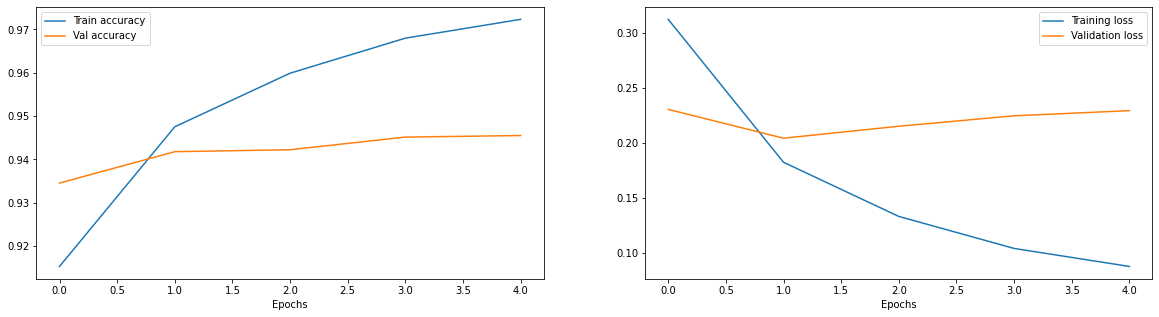

In [41]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [42]:
df.iloc[test_idx]

,label,file
84469,8,./save_temp/captcha_test/train_mst_extra/8_230...
3124,e,./save_temp/captcha_test/train_mst_extra/e_230...
20469,w,./save_temp/captcha_test/train_mst_extra/w_230...
7859,w,./save_temp/captcha_test/train_mst_extra/w_230...
123802,n,./save_temp/captcha_test/train_mst_extra/n_230...
...,...,...
260269,5,./save_temp/captcha_test/train_mst_extra/5_230...
21957,b,./save_temp/captcha_test/train_mst_extra/b_230...
47703,d,./save_temp/captcha_test/train_mst_extra/d_230...
62273,w,./save_temp/captcha_test/train_mst_extra/w_230...


In [43]:
# evaluate loss and accuracy in test dataset
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

673/673 [==============================] - 32s 48ms/step - loss: 0.2340 - accuracy: 0.9462


{'loss': 0.23399831354618073, 'accuracy': 0.9462063312530518}

In [44]:
fmodel = './save_temp/captcha_test/model_save/model_final.h5'
model.save(fmodel)

In [45]:
from tensorflow.keras.models import load_model

In [46]:
fn_model = load_model(fmodel)

#### Predict

In [47]:
MST_DIR_JPG_TEST = './save_temp/captcha_test/test_mst/jpg/'
MST_DIR_PNG_TEST = './save_temp/captcha_test/test_mst/png/'

In [50]:
def predict_img(model, fimg):
    format_y = lambda y: ''.join(map(lambda x: chr(int(x)), y))
    chars_ls = fimg.split("/")[-1].split(".")[0].split("_")[0]
    res_chars = ''
    y_pred_ls = []
    y_pred_ls_all = []
    for pos, c in enumerate(chars_ls):
        chars_img = process_char(fimg, pos, num_chars=5, chop_wd=[0, -2, 2], chop_width=[0, 2])
        y_pred_ls = []
        for cimg in chars_img:
            im = np.array([np.repeat(x, 3, axis=1) for x in cimg[0]], np.uint8)
            im = np.array(im) / 255.0
            y_pred = model.predict(np.array([im]), verbose=0)
            am = tf.math.argmax(y_pred, axis=-1)
            c = format_y(am[0])
            y_pred_ls.append({'c': c, 'pc': y_pred[0][0][am][0][0]})

        dft = pd.DataFrame.from_records(y_pred_ls)        
        dft = dft.groupby('c')['pc'].agg(['count', 'max']).reset_index()\
                    .sort_values(by=['count'], ascending=False).head(2)
        
        # fix the ad hoc case r, h
        if set(dft['c']) == set(['r', 'h']):
            top_char = 'r'
        else: 
            top_char = dft.sort_values(by=['max'], ascending=False).head(1).iloc[0][0]
        
        y_pred_ls_all.append(y_pred_ls)

        res_chars += top_char
    
    return {
        'match': (res_chars == chars_ls), 
        'predict': res_chars, 
        'input': chars_ls, 
        'params': y_pred_ls_all
    }

In [51]:
# Predict folder
files = glob.glob(os.path.join(MST_DIR_PNG_TEST, "*.png"))
# files = glob.glob(os.path.join(MST_DIR_PNG, "*.png"))

pred_captcha_dir = [predict_img(fn_model, f) for f in files]

In [52]:
# y_pred_ls = [{'c': 'n', 'pc': 0.22}, {'c': 'h', 'pc': 0.22}]
# dft = pd.DataFrame.from_records(y_pred_ls)
# dft = dft.groupby('c')['pc'].agg(['count', 'max']).reset_index()\
#                     .sort_values(by=['count'], ascending=False).head(2)
# if len(set(list(dft['c'])) - set(['n', 'h'])) == 0:
#     print('yes')

In [53]:
df_pred = pd.DataFrame(pred_captcha_dir)
df_pred

,match,predict,input,params
0,True,yk2ng,yk2ng,"[[{'c': 'y', 'pc': 1.0}, {'c': 'y', 'pc': 0.99..."
1,True,gaawx,gaawx,"[[{'c': 'g', 'pc': 1.0}, {'c': 'c', 'pc': 0.93..."
2,True,ckpfr,ckpfr,"[[{'c': 'c', 'pc': 0.9999969}, {'c': 'c', 'pc'..."
3,False,6xx3g,6hx3g,"[[{'c': '6', 'pc': 1.0}, {'c': '6', 'pc': 1.0}..."
4,True,ekyy4,ekyy4,"[[{'c': 'e', 'pc': 1.0}, {'c': 'e', 'pc': 1.0}..."
5,True,543r3,543r3,"[[{'c': '5', 'pc': 1.0}, {'c': '5', 'pc': 1.0}..."
6,True,xx56d,xx56d,"[[{'c': 'x', 'pc': 1.0}, {'c': 'x', 'pc': 1.0}..."
7,True,nxpnh,nxpnh,"[[{'c': 'n', 'pc': 1.0}, {'c': 'n', 'pc': 1.0}..."
8,True,2y8ry,2y8ry,"[[{'c': '2', 'pc': 1.0}, {'c': '2', 'pc': 1.0}..."
9,False,bmbyr,bm3wr,"[[{'c': 'b', 'pc': 0.9999943}, {'c': 'b', 'pc'..."


In [54]:
df_pred['match'].value_counts()

True     21
False     3
Name: match, dtype: int64

In [55]:
fn_mis_match = lambda s1, s2: [{'input': c1, 'predict': c2} for c1, c2 in zip(s1, s2) if c1 != c2]
failed_cases = df_pred[df_pred['match']==False].apply(lambda x: fn_mis_match(x['input'], 
                                                                             x['predict']), axis=1)
failed_cases = list(itertools.chain.from_iterable(list(failed_cases)))
df_failed_cases = pd.DataFrame(failed_cases).groupby(['input', 'predict']).size().reset_index(name='count')\
                        .sort_values('input')
df_failed_cases

,input,predict,count
0,3,b,1
1,h,x,1
2,r,3,1
3,w,y,1


#### Detect the reason why failed

In [351]:
# df_pred[df_pred['match']==False]

In [352]:
# df_pred[df_pred['match']==False].iloc[5], df_pred[df_pred['match']==False].iloc[5, 3]

In [353]:
# df_pred[df_pred['match']==False].iloc[1], df_pred[df_pred['match']==False].iloc[1,3]

## Backup

In [ ]:
# def remove_noise(fimg):
#     image = cv2.imread(fimg, cv2.IMREAD_GRAYSCALE)
#     kernel = np.ones((2, 2), np.uint8)

#     dilated_img = cv2.dilate(image, kernel, iterations=1)
    
#     # conver to black and white
#     # dilated_img[dilated_img!=255] = 0

    
#     # remove lines or columns with all 0 to 255
#     cols = [i for i in range(dilated_img.shape[1]) if not np.any(dilated_img[:, i])]
#     rows = [i for i in range(dilated_img.shape[0]) if not np.any(dilated_img[i, :])]
    
#     dilated_img[:, cols] = 255
#     dilated_img[rows, :] = 255
    
#     return dilated_img


# def chop_window_sizes(arr, num_chars=5, chop_wd = [0, -2, -4, 2, 4], chop_width=[0]):
    
#     # Chop redundant background on left and right 
#     first =  min([x for x in [np.argmax(x!=255) for x in arr] if x!= 0])
#     last = max([x for x in [arr.shape[1]-np.argmax(np.flip(x)!=255) for x in arr] if x!= arr.shape[1]])
#     equal_size = (last - first) // num_chars
    
#     # Chop multi size
#     arr_chars = []
#     chop_size = [(x, x, w) for x in chop_wd for w in chop_width]   
#     for i in range(num_chars):
#         arr_chars.append([arr[:, max(0, i*equal_size+s[1]) : i*equal_size+equal_size+s[2]]
#                                    for s in chop_size])
    
#     # padding for make equal width
#     max_size = max([i.shape[1] for ch in arr_chars for i in ch]) + 4
#     res_chars = []
#     for ac in arr_chars:
#         res_chars.append([np.column_stack((np.full((x.shape[0], (max_size - x.shape[1])//2), 255, np.uint8), x, 
#                                            np.full((x.shape[0], (max_size - x.shape[1])//2), 255, np.uint8))) 
#                                     for x in ac])

#     return res_chars


# def extract_contours_all(img_list):
#     def extract_contours_(img):
#         img = imutils.resize(img, width=32, height=32)
#         img = cv2.GaussianBlur(img, (5, 5), 0)
#         img = cv2.Canny(img, img.shape[0], img.shape[1])
#         cnts = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         # cnts_sorted = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])
#         cnts_sorted = cnts

#         chars = []
#         for i, c in enumerate(cnts_sorted):

#             # compute the bounding box of the contour
#             (x, y, w, h) = cv2.boundingRect(c)

#             if w >= 10 and h >= 10:
#                 roi = img[y:y + h, x:x + w]
#                 thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#                 (tH, tW) = thresh.shape

#                 # if the width is greater than the height, resize along the width dimension
#                 rsw, rsh = 32, 32                
#                 thresh = imutils.resize(thresh, width=rsw) if tW > tH else \
#                                 imutils.resize(thresh, height=rsh)
#                 (tH, tW) = thresh.shape
#                 dX = int(max(0, rsw - tW) / 2.0)
#                 dY = int(max(0, rsh - tH) / 2.0)

#                 # pad the image and force 32x32 dimensions
#                 padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, 
#                                             borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
#                 padded = cv2.resize(padded, (rsw, rsh))
#                 padded = padded.astype("float32")
#                 padded = np.expand_dims(padded, axis=-1)
#                 chars.append((padded, (x, y, w, h)))

#         chars = sorted(chars, key=lambda c: c[1][2], reverse=True)
#         return [chars[0]]
    
    
#     def extract_contours_list_(img_list):
#         chars_list = None
#         for img in img_list:
#             cts = extract_contours_(img)
#             if len(cts) > 0:
#                 chars_list = [cts[0]] if chars_list is None else chars_list + [cts[0]]
#         # chars_list = sorted(chars_list, key=lambda c: c[1][2], reverse=True)
        
#         return chars_list

        
#     return extract_contours_list_(img_list)


# def display_multi_2d(img_list, ncols=5, idepth=None):
    
#     nrows = sum([math.ceil(len(x) / ncols) for x in img_list])

#     plt.figure()
#     f, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
    
#     iprev = 0
#     for i in range(len(img_list)):
#         for j in range(len(img_list[i])):
#             irow = iprev + math.floor(j / ncols)
#             icol = j - math.floor(j / ncols) * ncols
#             img = img_list[i][j] if idepth is None else img_list[i][j][idepth]
#             axes[icol].imshow(img) if nrows == 1 else axes[irow, icol].imshow(img)
#         iprev = irow + 1
    
# def display_multi(img_list, ncols=5, idepth=None):
    
#     nrows = math.ceil(len(img_list) / ncols)

#     plt.figure()
#     f, axes = plt.subplots(nrows, ncols if nrows > 1 else len(img_list))
#     for i in range(len(img_list)):
#         irow, icol = math.floor(i/ncols), i%ncols
#         img = img_list[i] if idepth is None else img_list[i][idepth]
#         if len(img_list) == 1:
#             axes.imshow(img)
#         else:
#             axes[icol].imshow(img) if nrows == 1 else axes[irow, icol].imshow(img)

# def process_char(fimg, pos, num_chars=5, chop_wd = [0, -2, -4, 2, 4], chop_width=[0]):
#     img_rn = remove_noise(fimg)
#     chop_imgs = chop_window_sizes(img_rn, num_chars, chop_wd, chop_width)
#     all_chars = extract_contours_all(chop_imgs[pos])

#     return all_chars